In [1]:
from aicsimageio import AICSImage
import dask.array as da
from skimage.io import imshow
import skimage
import numpy as np

import os

from stardist.models import StarDist2D 
import matplotlib.patches as mpatches
from skimage.color import label2rgb


from csbdeep.utils import normalize
from stardist.plot import render_label
import matplotlib.pyplot as plt

In [2]:
#fpath = 'Z:\\Stefanie Bader\\SARS-Histo\\21.2810-covivo127-P2vsP21\\MPO\\P2-D4\\3M10_11.11.2021_21.29.16.16 - Annotation 1\\'
#fpath = 'Z:\\Stefanie Bader\\SARS-Histo\\21.2810-covivo127-P2vsP21\\SARS\\P21-D7\\4M18_12.11.2021_02.52.12.12 - Annotation 1\\'
fpath = 'Z:\\Stefanie Bader\\SARS-Histo\\21.2810-covivo127-P2vsP21\\CD3\\P21-D7\\2M17_04.11.2021_19.35.43.43 - Annotation 1\\'

flist = os.listdir(fpath)
test_image_fpath = os.path.join(fpath,flist[0])
print(flist)


['2M17_04.11.2021_19.35.43_Default_Extended.tif', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile0.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile1.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile10.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile11.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile12.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile13.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile14.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile15.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile2.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile3.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile4.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile5.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile6.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile7.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile8.txt', '2M17_04.11.2021_19.35.43_Default_Extended.tif_tile9.txt']


In [3]:
test_image = AICSImage(test_image_fpath)
test_image.shape

Failed to parse XML for the provided file. Error: syntax error: line 1, column 0


(1, 1, 1, 62720, 70144, 3)

In [4]:
im_da = test_image.get_image_dask_data("YXS",T=0,C=0,Z=0)
im_da.shape
im_da = im_da[20000:22500,22500:25000]


In [5]:
smallRoi = im_da

CPU times: total: 33 s
Wall time: 17.1 s


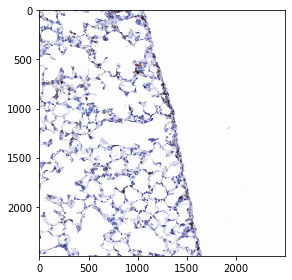

In [6]:
%%time
im = np.asarray(smallRoi)
imshow(im)

In [7]:
im2 = skimage.color.rgb2gray(im)
im2 = skimage.util.invert(im2)
#imshow(im2)

In [8]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [9]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

# mi, ma = np.percentile(img[::8], [1,99.8])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
normalizer = MyNormalizer(mi, ma)

In [10]:
%%time
labels, _ = model.predict_instances_big(im2,axes='YX', block_size=2048,min_overlap=128, context=128,show_progress=True)

effective: block_size=(2048, 2048), min_overlap=(128, 128), context=(128, 128)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.96s/it]

CPU times: total: 36.6 s
Wall time: 8.33 s


matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


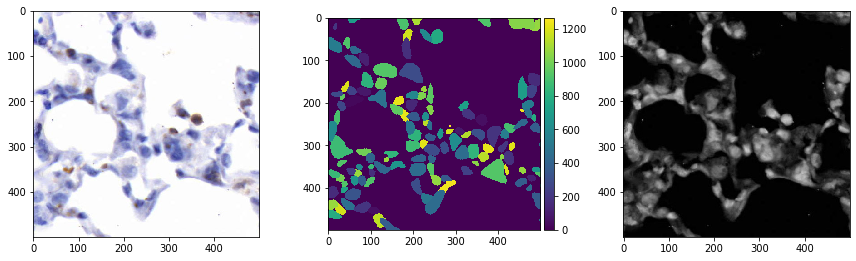

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
imshow(im[0:500,0:500])
plt.subplot(1,3,2)
imshow(labels[0:500,0:500])
plt.subplot(1,3,3)
imshow(im2[0:500,0:500])

In [12]:
%%time
im3 = skimage.color.rgb2hed(im)

CPU times: total: 359 ms
Wall time: 356 ms


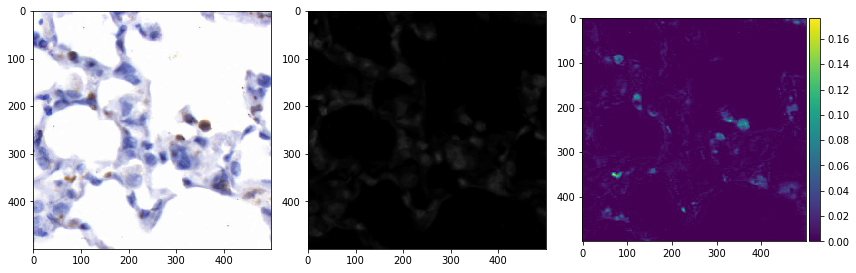

In [13]:
dab = im3[:,:,2]
blue = im3[:,:,0]

plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
imshow(im[0:500,0:500])
plt.subplot(1,3,2)
imshow(blue[0:500,0:500])
plt.subplot(1,3,3)
imshow(dab[0:500,0:500])


In [14]:
res = skimage.measure.regionprops(labels,intensity_image=dab)
blueres = skimage.measure.regionprops(labels,intensity_image=blue)
print(np.mean([r.area for r in res]))

503.2307692307692


In [15]:
x = [d for d, b in zip(res, blueres) if d.area > 200 and b.intensity_mean > 0.020]
totalCells = len(x)

p = [d for d, b in zip(res, blueres) if d.area > 200 and d.intensity_mean > 0.02 and b.intensity_mean > 0.020]
posCells = len(p)

print(totalCells,posCells)

1278 141


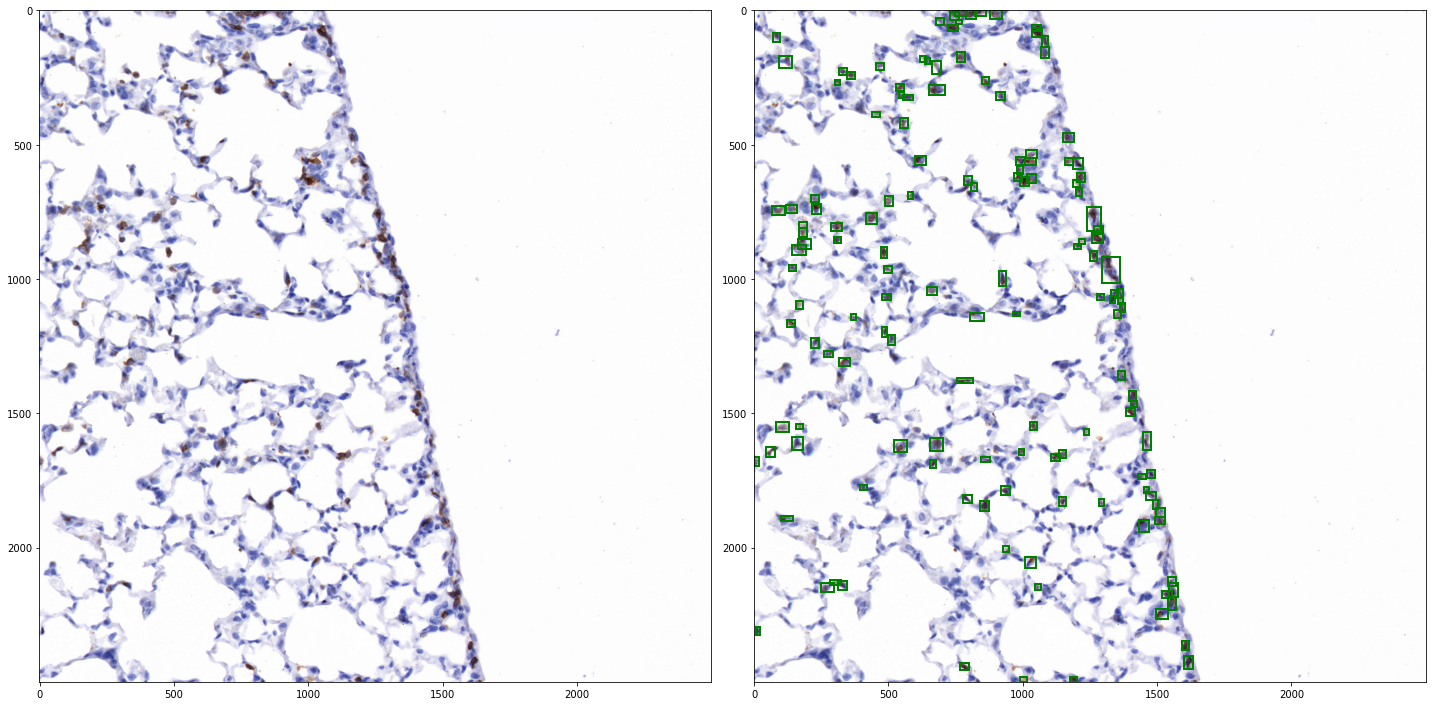

In [16]:

fig, ax = plt.subplots(1,2,figsize=(20, 40))



ax[0].imshow(im)
ax[1].imshow(im)

for r in p:
    minr, minc, maxr, maxc = r.bbox
    if r.intensity_mean < 0.02:
        pass
        #rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
         #                         fill=False, edgecolor='red', linewidth=2)
    else:
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='green', linewidth=2)
       
    ax[1].add_patch(rect)
    


plt.tight_layout()
plt.show()
